# **1. 데이터준비하기**

* 가수 임재범, 개그맨 정성호

In [31]:
import random
import os
import shutil
import cv2
import glob
import torch
import torchvision
import numpy as np
import timm
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from time import time
from torchvision import datasets, models, transforms
from tempfile import TemporaryDirectory
from torch.optim import lr_scheduler

In [20]:
# !pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 82.9 MB/s eta 0:00:00


In [2]:
data_root = '/content/drive/MyDrive/Korea it 아카데미/Project/Data/5'
file_root = f'{data_root}/data'

train_root =f'{data_root}/train'
val_root =f'{data_root}/val'
test_root =f'{data_root}/test'

cls_list = os.listdir(file_root)

print(cls_list)

['Lim', 'Jung']


In [3]:
for folder in [train_root, val_root, test_root] :

    if not os.path.exists(folder) :
        os.makedirs(folder)

    for cls in cls_list :
        cls_folder = f'{folder}/{cls}'

        if not os.path.exists(cls_folder) :
            os.makedirs(cls_folder)

In [4]:
random.seed(2024)

In [5]:
for cls in cls_list :
    file_list = os.listdir(f'{file_root}/{cls}')
    random.shuffle(file_list)
    test_ratio = 0.1
    num_file = len(file_list)

    test_list= file_list[: int(num_file * test_ratio)]
    val_list= file_list[int(num_file * test_ratio) : int(num_file * test_ratio) * 2]
    train_list= file_list[int(num_file * test_ratio) * 2 :]

    for i in test_list:
        shutil.copyfile(f'{file_root}/{cls}/{i}', f'{test_root}/{cls}/{i}')

    for i in val_list:
        shutil.copyfile(f'{file_root}/{cls}/{i}', f'{val_root}/{cls}/{i}')

    for i in train_list:
        shutil.copyfile(f'{file_root}/{cls}/{i}', f'{train_root}/{cls}/{i}')

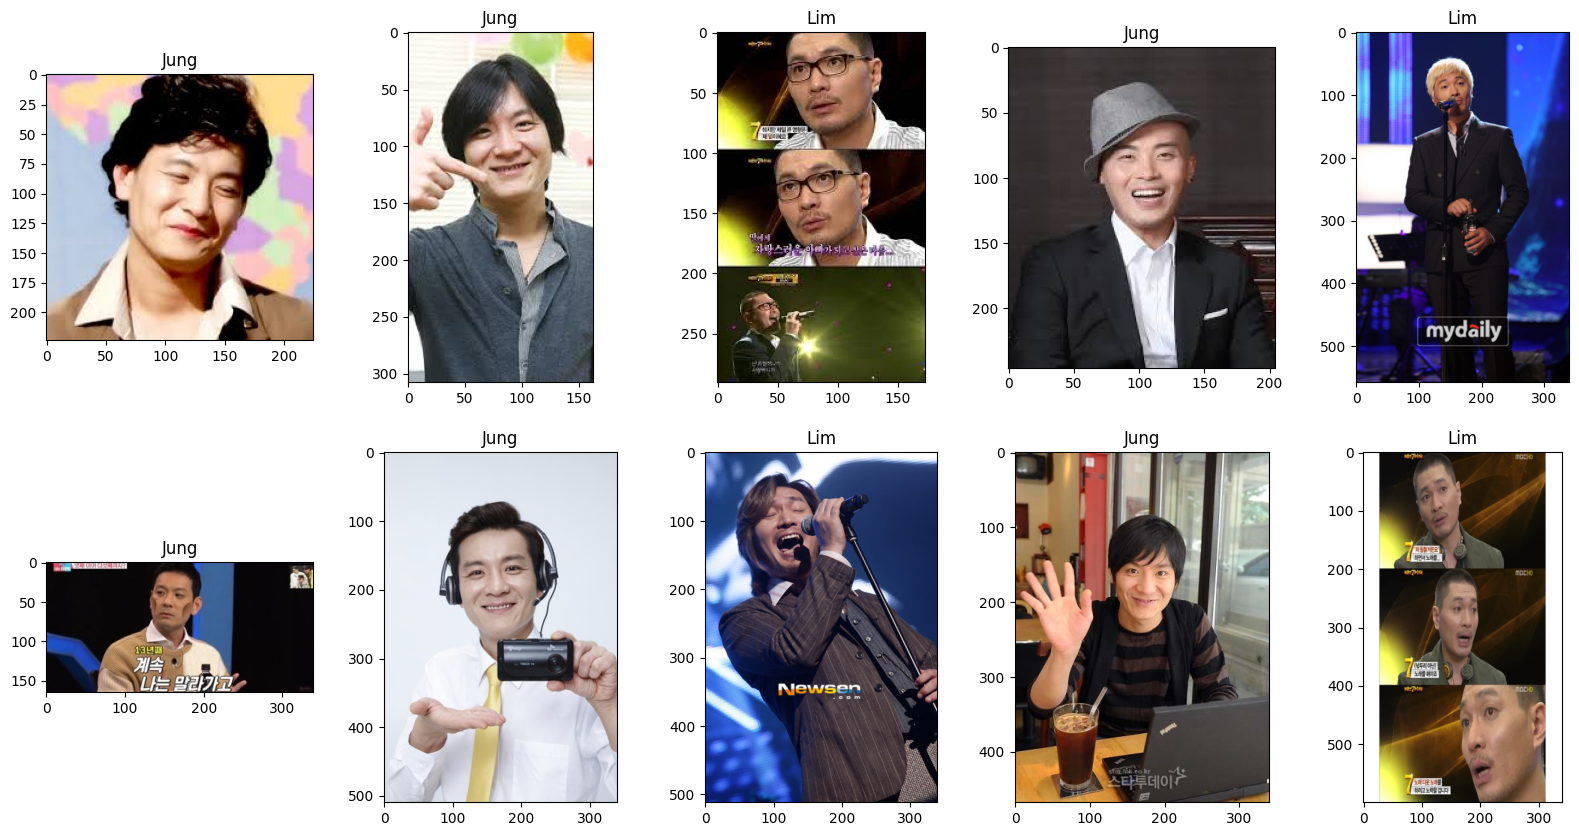

In [6]:
import matplotlib.pyplot as plt
import glob
from PIL import Image

test_file_list = glob.glob(f"{test_root}/*/*")
random.shuffle(test_file_list)
plt.figure(figsize = (20,10))

for i in range(10):
    test_img_path = os.path.join(test_root, test_file_list[i])
    ori_img = Image.open(test_img_path).convert('RGB')
    plt.subplot(2, 5, (i+1))
    plt.title(test_file_list[i].split('/')[-2])
    plt.imshow(ori_img)

plt.show()









In [7]:
IMG_SIZE = (224, 224)

data_transforms = {
    'train' : transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test' : transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [8]:
image_datasets = {x : datasets.ImageFolder(os.path.join(data_root, x),
                                           data_transforms[x])
                                        for x in ['train', 'val', 'test']}


In [9]:
dataloaders = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size = 16,
                                          shuffle = True, num_workers = 4)
                for x in ['train', 'val', 'test']}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

{'train': 800, 'val': 100, 'test': 100}
['Jung', 'Lim']


In [35]:
test_root = f'{data_root}/test'

test_file_list = glob.glob(f'{test_root}/*/*')
random.shuffle(test_file_list)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [12]:

test_data_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_test = datasets.ImageFolder(os.path.join(data_root, 'test'),
                                           test_data_transform)


test_dataloaders = torch.utils.data.DataLoader(image_test, batch_size = 16,
                                          shuffle = False)

test_dataset_size = len(image_test)
class_names = image_test.classes

print(test_dataset_size)
print(class_names)




100
['Jung', 'Lim']


In [44]:
def train_model(model, loss_func, optimizer, dataloader, dataset_size, model_name, model_dir, num_epochs, device) :
    since = time()

    # 임시 디렉토리를 생성하고 작업이 종료된 후 자동으로 삭제되도록 관리

    with TemporaryDirectory() as tempdir :
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        print(resnet34_model)
        torch.save(model.state_dict(), best_model_params_path)

        best_acc = 0.0
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []

        for epoch in range(num_epochs) :
            print(f'Epoch {epoch + 1} / {num_epochs}')
            print('-' * 10)

            for phase in ['train', 'val'] :

                if phase == 'train' :
                    model.train()

                else :
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in tqdm(dataloaders[phase]) :
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train') :
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = loss_func(outputs, labels)

                        if phase == 'train' :
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train' :
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss : {epoch_loss : .4f} Acc : {epoch_acc : .4f}')

                if phase == 'train' :
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc.item())

                else :
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc.item())

                    if epoch_acc > best_acc :
                        best_acc = epoch_acc

                        if not os.path.exists(model_dir) :
                            os.makedirs(model_dir)

                        model_save_path = os.path.join(model_dir, f'{model_name}.pth')
                        torch.save(model.state_dict(), model_save_path)

            print()

        time_elapsed = time() - since
        print(f'Training coomplete in {time_elapsed // 60 : .0f}m {time_elapsed % 60 : .0f}s')
        print(f'Best val Acc : {best_acc : .4f}')

    return [train_loss, val_loss, train_acc, val_acc]

In [48]:
project_root = '/content/drive/MyDrive/Korea it 아카데미/Project/5.얼굴 분류'

if not os.path.isdir(project_root) :
    os.mkdir(project_root)

model_dir = f'{project_root}/models'

if not os.path.isdir(model_dir) :
    os.mkdir(model_dir)

num_epochs = 100
num_class = len(os.listdir(train_root))
loss_func = nn.CrossEntropyLoss()

# 학습률 스케쥴러
# 학습 중에 학습률을 점진적으로 조정 할 수 있음
# StepLR : 일정 에포크 수 마다 학습률을 감소시키는 역활
# step_size : 학습률을 조정하는 주기
# gamma : 학습률을 감소시키는 비율

resnet34_model = timm.create_model('resnet34', pretrained = True, num_classes = num_class).to(device)
optimizer = optim.Adam(resnet34_model.parameters(), lr = 0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

In [49]:
resnet34 = train_model(resnet34_model, loss_func, optimizer, dataloaders,
            dataset_sizes, 'JungLim_resnet34', model_dir, num_epochs, device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


train Loss :  0.6314 Acc :  0.7450


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


val Loss :  0.5750 Acc :  0.8000

Epoch 2 / 100
----------


100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


train Loss :  0.4939 Acc :  0.8625


100%|██████████| 7/7 [00:00<00:00,  9.62it/s]


val Loss :  0.4599 Acc :  0.8900

Epoch 3 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.69it/s]


train Loss :  0.3551 Acc :  0.9138


100%|██████████| 7/7 [00:00<00:00,  9.52it/s]


val Loss :  0.3541 Acc :  0.9000

Epoch 4 / 100
----------


100%|██████████| 50/50 [00:08<00:00,  5.99it/s]


train Loss :  0.2463 Acc :  0.9425


100%|██████████| 7/7 [00:00<00:00,  8.30it/s]


val Loss :  0.2755 Acc :  0.9000

Epoch 5 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.45it/s]


train Loss :  0.1725 Acc :  0.9587


100%|██████████| 7/7 [00:00<00:00,  9.14it/s]


val Loss :  0.2568 Acc :  0.9300

Epoch 6 / 100
----------


100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


train Loss :  0.1182 Acc :  0.9825


100%|██████████| 7/7 [00:00<00:00,  8.21it/s]


val Loss :  0.2231 Acc :  0.9300

Epoch 7 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.52it/s]


train Loss :  0.0886 Acc :  0.9788


100%|██████████| 7/7 [00:00<00:00,  9.59it/s]


val Loss :  0.2019 Acc :  0.9200

Epoch 8 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  7.65it/s]


train Loss :  0.0489 Acc :  0.9938


100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


val Loss :  0.2040 Acc :  0.9400

Epoch 9 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.59it/s]


train Loss :  0.0386 Acc :  0.9975


100%|██████████| 7/7 [00:00<00:00,  9.51it/s]


val Loss :  0.1905 Acc :  0.9500

Epoch 10 / 100
----------


100%|██████████| 50/50 [00:07<00:00,  6.83it/s]


train Loss :  0.0327 Acc :  0.9975


100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


val Loss :  0.1842 Acc :  0.9000

Epoch 11 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.65it/s]


train Loss :  0.0252 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  9.43it/s]


val Loss :  0.1804 Acc :  0.9200

Epoch 12 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  7.50it/s]


train Loss :  0.0317 Acc :  0.9962


100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


val Loss :  0.1848 Acc :  0.9100

Epoch 13 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  9.12it/s]


train Loss :  0.0213 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  9.44it/s]


val Loss :  0.1866 Acc :  0.9100

Epoch 14 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  7.71it/s]


train Loss :  0.0253 Acc :  0.9988


100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


val Loss :  0.1869 Acc :  0.9100

Epoch 15 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  9.16it/s]


train Loss :  0.0306 Acc :  0.9950


100%|██████████| 7/7 [00:00<00:00,  9.41it/s]


val Loss :  0.1817 Acc :  0.9400

Epoch 16 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  8.19it/s]


train Loss :  0.0225 Acc :  0.9988


100%|██████████| 7/7 [00:01<00:00,  5.58it/s]


val Loss :  0.1879 Acc :  0.9100

Epoch 17 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.82it/s]


train Loss :  0.0207 Acc :  0.9975


100%|██████████| 7/7 [00:00<00:00,  9.45it/s]


val Loss :  0.1832 Acc :  0.9300

Epoch 18 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  8.33it/s]


train Loss :  0.0168 Acc :  1.0000


100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


val Loss :  0.1920 Acc :  0.9100

Epoch 19 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.70it/s]


train Loss :  0.0278 Acc :  0.9962


100%|██████████| 7/7 [00:00<00:00,  9.51it/s]


val Loss :  0.1835 Acc :  0.9200

Epoch 20 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.40it/s]


train Loss :  0.0305 Acc :  0.9925


100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


val Loss :  0.1793 Acc :  0.9300

Epoch 21 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  7.43it/s]


train Loss :  0.0197 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  8.89it/s]


val Loss :  0.1766 Acc :  0.9300

Epoch 22 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.90it/s]


train Loss :  0.0233 Acc :  0.9988


100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


val Loss :  0.1801 Acc :  0.9000

Epoch 23 / 100
----------


100%|██████████| 50/50 [00:07<00:00,  6.87it/s]


train Loss :  0.0264 Acc :  0.9975


100%|██████████| 7/7 [00:00<00:00,  9.23it/s]


val Loss :  0.1764 Acc :  0.9100

Epoch 24 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  9.09it/s]


train Loss :  0.0197 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  9.18it/s]


val Loss :  0.1839 Acc :  0.9000

Epoch 25 / 100
----------


100%|██████████| 50/50 [00:07<00:00,  6.52it/s]


train Loss :  0.0191 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  9.49it/s]


val Loss :  0.1830 Acc :  0.9300

Epoch 26 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.98it/s]


train Loss :  0.0220 Acc :  0.9962


100%|██████████| 7/7 [00:00<00:00,  9.22it/s]


val Loss :  0.1878 Acc :  0.9100

Epoch 27 / 100
----------


100%|██████████| 50/50 [00:07<00:00,  6.76it/s]


train Loss :  0.0179 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  8.31it/s]


val Loss :  0.1722 Acc :  0.9200

Epoch 28 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.92it/s]


train Loss :  0.0286 Acc :  0.9950


100%|██████████| 7/7 [00:00<00:00,  9.38it/s]


val Loss :  0.1947 Acc :  0.9100

Epoch 29 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  7.83it/s]


train Loss :  0.0197 Acc :  1.0000


100%|██████████| 7/7 [00:01<00:00,  5.69it/s]


val Loss :  0.1786 Acc :  0.9200

Epoch 30 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.72it/s]


train Loss :  0.0234 Acc :  0.9975


100%|██████████| 7/7 [00:00<00:00,  9.51it/s]


val Loss :  0.1716 Acc :  0.9400

Epoch 31 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  8.28it/s]


train Loss :  0.0174 Acc :  1.0000


100%|██████████| 7/7 [00:01<00:00,  5.94it/s]


val Loss :  0.1753 Acc :  0.9200

Epoch 32 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.45it/s]


train Loss :  0.0217 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  9.53it/s]


val Loss :  0.1827 Acc :  0.9100

Epoch 33 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.39it/s]


train Loss :  0.0204 Acc :  0.9988


100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


val Loss :  0.1891 Acc :  0.9200

Epoch 34 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.55it/s]


train Loss :  0.0205 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  9.33it/s]


val Loss :  0.1774 Acc :  0.9300

Epoch 35 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.56it/s]


train Loss :  0.0202 Acc :  0.9988


100%|██████████| 7/7 [00:01<00:00,  5.83it/s]


val Loss :  0.1844 Acc :  0.9400

Epoch 36 / 100
----------


100%|██████████| 50/50 [00:07<00:00,  7.04it/s]


train Loss :  0.0253 Acc :  0.9950


100%|██████████| 7/7 [00:00<00:00,  9.09it/s]


val Loss :  0.1873 Acc :  0.9100

Epoch 37 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.89it/s]


train Loss :  0.0142 Acc :  1.0000


100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


val Loss :  0.1842 Acc :  0.9200

Epoch 38 / 100
----------


100%|██████████| 50/50 [00:07<00:00,  6.74it/s]


train Loss :  0.0221 Acc :  0.9975


100%|██████████| 7/7 [00:00<00:00,  9.19it/s]


val Loss :  0.1782 Acc :  0.9400

Epoch 39 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  9.10it/s]


train Loss :  0.0269 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  9.21it/s]


val Loss :  0.1770 Acc :  0.9200

Epoch 40 / 100
----------


100%|██████████| 50/50 [00:07<00:00,  6.30it/s]


train Loss :  0.0170 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  9.35it/s]


val Loss :  0.1840 Acc :  0.9000

Epoch 41 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.95it/s]


train Loss :  0.0203 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  9.36it/s]


val Loss :  0.2099 Acc :  0.9100

Epoch 42 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  7.15it/s]


train Loss :  0.0218 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  8.40it/s]


val Loss :  0.1861 Acc :  0.9300

Epoch 43 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  9.00it/s]


train Loss :  0.0194 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  8.98it/s]


val Loss :  0.1864 Acc :  0.9100

Epoch 44 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  7.87it/s]


train Loss :  0.0207 Acc :  0.9988


100%|██████████| 7/7 [00:01<00:00,  5.55it/s]


val Loss :  0.1863 Acc :  0.9200

Epoch 45 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.74it/s]


train Loss :  0.0164 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  9.05it/s]


val Loss :  0.1792 Acc :  0.9000

Epoch 46 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  8.19it/s]


train Loss :  0.0261 Acc :  0.9962


100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


val Loss :  0.1765 Acc :  0.9000

Epoch 47 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.55it/s]


train Loss :  0.0346 Acc :  0.9938


100%|██████████| 7/7 [00:00<00:00,  9.14it/s]


val Loss :  0.1814 Acc :  0.9100

Epoch 48 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.36it/s]


train Loss :  0.0139 Acc :  1.0000


100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


val Loss :  0.1750 Acc :  0.9200

Epoch 49 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  7.28it/s]


train Loss :  0.0191 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  9.14it/s]


val Loss :  0.1869 Acc :  0.9100

Epoch 50 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


train Loss :  0.0235 Acc :  0.9988


100%|██████████| 7/7 [00:01<00:00,  5.94it/s]


val Loss :  0.1747 Acc :  0.9200

Epoch 51 / 100
----------


100%|██████████| 50/50 [00:07<00:00,  6.66it/s]


train Loss :  0.0189 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  9.03it/s]


val Loss :  0.1754 Acc :  0.9000

Epoch 52 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.91it/s]


train Loss :  0.0177 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  9.20it/s]


val Loss :  0.1759 Acc :  0.9200

Epoch 53 / 100
----------


100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


train Loss :  0.0188 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  9.21it/s]


val Loss :  0.1786 Acc :  0.9200

Epoch 54 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.77it/s]


train Loss :  0.0161 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  9.11it/s]


val Loss :  0.1808 Acc :  0.9100

Epoch 55 / 100
----------


100%|██████████| 50/50 [00:07<00:00,  6.39it/s]


train Loss :  0.0262 Acc :  0.9962


100%|██████████| 7/7 [00:00<00:00,  9.38it/s]


val Loss :  0.1898 Acc :  0.9100

Epoch 56 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  9.21it/s]


train Loss :  0.0159 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  9.16it/s]


val Loss :  0.1700 Acc :  0.9000

Epoch 57 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  7.68it/s]


train Loss :  0.0224 Acc :  0.9962


100%|██████████| 7/7 [00:01<00:00,  5.43it/s]


val Loss :  0.1766 Acc :  0.9100

Epoch 58 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.82it/s]


train Loss :  0.0134 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  9.11it/s]


val Loss :  0.1873 Acc :  0.9200

Epoch 59 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  7.95it/s]


train Loss :  0.0155 Acc :  1.0000


100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


val Loss :  0.1704 Acc :  0.9200

Epoch 60 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.41it/s]


train Loss :  0.0128 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  8.90it/s]


val Loss :  0.1782 Acc :  0.9100

Epoch 61 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  7.95it/s]


train Loss :  0.0254 Acc :  0.9975


100%|██████████| 7/7 [00:01<00:00,  5.18it/s]


val Loss :  0.1821 Acc :  0.9200

Epoch 62 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.38it/s]


train Loss :  0.0168 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


val Loss :  0.1694 Acc :  0.9300

Epoch 63 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  8.07it/s]


train Loss :  0.0243 Acc :  0.9975


100%|██████████| 7/7 [00:01<00:00,  5.62it/s]


val Loss :  0.1788 Acc :  0.9300

Epoch 64 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.44it/s]


train Loss :  0.0197 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  8.55it/s]


val Loss :  0.1707 Acc :  0.9400

Epoch 65 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  8.08it/s]


train Loss :  0.0194 Acc :  1.0000


100%|██████████| 7/7 [00:01<00:00,  5.43it/s]


val Loss :  0.1804 Acc :  0.9200

Epoch 66 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  8.08it/s]


train Loss :  0.0261 Acc :  0.9975


100%|██████████| 7/7 [00:00<00:00,  9.06it/s]


val Loss :  0.1918 Acc :  0.9000

Epoch 67 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  7.95it/s]


train Loss :  0.0220 Acc :  1.0000


100%|██████████| 7/7 [00:01<00:00,  5.58it/s]


val Loss :  0.1891 Acc :  0.9200

Epoch 68 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.46it/s]


train Loss :  0.0174 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  8.73it/s]


val Loss :  0.1908 Acc :  0.9000

Epoch 69 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  8.23it/s]


train Loss :  0.0185 Acc :  1.0000


100%|██████████| 7/7 [00:01<00:00,  5.53it/s]


val Loss :  0.1728 Acc :  0.9100

Epoch 70 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.40it/s]


train Loss :  0.0160 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  9.12it/s]


val Loss :  0.1763 Acc :  0.9100

Epoch 71 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  8.29it/s]


train Loss :  0.0136 Acc :  1.0000


100%|██████████| 7/7 [00:01<00:00,  5.50it/s]


val Loss :  0.1859 Acc :  0.9100

Epoch 72 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.39it/s]


train Loss :  0.0166 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  9.11it/s]


val Loss :  0.1802 Acc :  0.9200

Epoch 73 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  8.18it/s]


train Loss :  0.0192 Acc :  0.9975


100%|██████████| 7/7 [00:01<00:00,  5.78it/s]


val Loss :  0.1829 Acc :  0.9000

Epoch 74 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  8.18it/s]


train Loss :  0.0184 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  8.80it/s]


val Loss :  0.1797 Acc :  0.9200

Epoch 75 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.75it/s]


train Loss :  0.0155 Acc :  1.0000


100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


val Loss :  0.1886 Acc :  0.9000

Epoch 76 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  7.22it/s]


train Loss :  0.0171 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  8.80it/s]


val Loss :  0.1909 Acc :  0.9000

Epoch 77 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  9.12it/s]


train Loss :  0.0132 Acc :  1.0000


100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


val Loss :  0.1843 Acc :  0.9100

Epoch 78 / 100
----------


100%|██████████| 50/50 [00:07<00:00,  6.67it/s]


train Loss :  0.0209 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  8.05it/s]


val Loss :  0.1786 Acc :  0.9100

Epoch 79 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.86it/s]


train Loss :  0.0215 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  9.09it/s]


val Loss :  0.1724 Acc :  0.9400

Epoch 80 / 100
----------


100%|██████████| 50/50 [00:08<00:00,  6.14it/s]


train Loss :  0.0196 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  8.94it/s]


val Loss :  0.1811 Acc :  0.9100

Epoch 81 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.98it/s]


train Loss :  0.0198 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  9.04it/s]


val Loss :  0.1745 Acc :  0.9100

Epoch 82 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  7.20it/s]


train Loss :  0.0209 Acc :  0.9975


100%|██████████| 7/7 [00:00<00:00,  8.20it/s]


val Loss :  0.1824 Acc :  0.9200

Epoch 83 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.79it/s]


train Loss :  0.0190 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]


val Loss :  0.1796 Acc :  0.9000

Epoch 84 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  7.53it/s]


train Loss :  0.0281 Acc :  0.9938


100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


val Loss :  0.1846 Acc :  0.9200

Epoch 85 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  9.00it/s]


train Loss :  0.0261 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  9.27it/s]


val Loss :  0.1810 Acc :  0.9200

Epoch 86 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  7.87it/s]


train Loss :  0.0207 Acc :  0.9975


100%|██████████| 7/7 [00:01<00:00,  5.52it/s]


val Loss :  0.1798 Acc :  0.9300

Epoch 87 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.63it/s]


train Loss :  0.0203 Acc :  0.9962


100%|██████████| 7/7 [00:00<00:00,  9.02it/s]


val Loss :  0.1786 Acc :  0.9200

Epoch 88 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  8.12it/s]


train Loss :  0.0187 Acc :  1.0000


100%|██████████| 7/7 [00:01<00:00,  5.83it/s]


val Loss :  0.1777 Acc :  0.9100

Epoch 89 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.65it/s]


train Loss :  0.0198 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  8.91it/s]


val Loss :  0.1781 Acc :  0.9000

Epoch 90 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  8.16it/s]


train Loss :  0.0182 Acc :  1.0000


100%|██████████| 7/7 [00:01<00:00,  5.70it/s]


val Loss :  0.1822 Acc :  0.9400

Epoch 91 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.60it/s]


train Loss :  0.0149 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  9.08it/s]


val Loss :  0.1771 Acc :  0.9000

Epoch 92 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.51it/s]


train Loss :  0.0252 Acc :  0.9988


100%|██████████| 7/7 [00:01<00:00,  5.59it/s]


val Loss :  0.1825 Acc :  0.9200

Epoch 93 / 100
----------


100%|██████████| 50/50 [00:06<00:00,  7.66it/s]


train Loss :  0.0217 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  9.29it/s]


val Loss :  0.1893 Acc :  0.9100

Epoch 94 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.43it/s]


train Loss :  0.0194 Acc :  0.9988


100%|██████████| 7/7 [00:01<00:00,  5.64it/s]


val Loss :  0.1936 Acc :  0.9000

Epoch 95 / 100
----------


100%|██████████| 50/50 [00:07<00:00,  7.12it/s]


train Loss :  0.0184 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  8.37it/s]


val Loss :  0.1862 Acc :  0.8900

Epoch 96 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.98it/s]


train Loss :  0.0190 Acc :  1.0000


100%|██████████| 7/7 [00:01<00:00,  6.30it/s]


val Loss :  0.1737 Acc :  0.9200

Epoch 97 / 100
----------


100%|██████████| 50/50 [00:07<00:00,  6.51it/s]


train Loss :  0.0161 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  9.16it/s]


val Loss :  0.1715 Acc :  0.9200

Epoch 98 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.93it/s]


train Loss :  0.0229 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  9.35it/s]


val Loss :  0.1714 Acc :  0.9200

Epoch 99 / 100
----------


100%|██████████| 50/50 [00:07<00:00,  6.67it/s]


train Loss :  0.0166 Acc :  0.9988


100%|██████████| 7/7 [00:00<00:00,  9.32it/s]


val Loss :  0.1777 Acc :  0.9100

Epoch 100 / 100
----------


100%|██████████| 50/50 [00:05<00:00,  8.73it/s]


train Loss :  0.0147 Acc :  1.0000


100%|██████████| 7/7 [00:00<00:00,  9.12it/s]

val Loss :  0.1835 Acc :  0.9100

Training coomplete in  12m  4s
Best val Acc :  0.9500


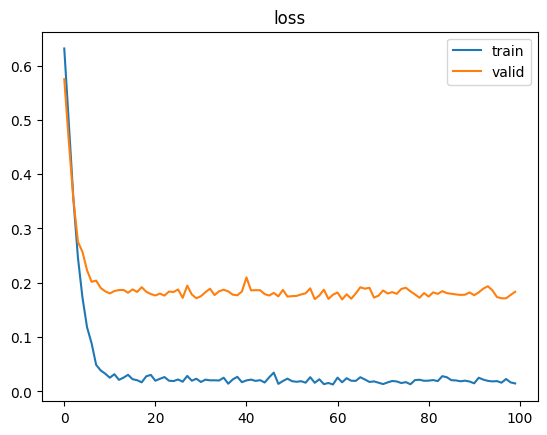

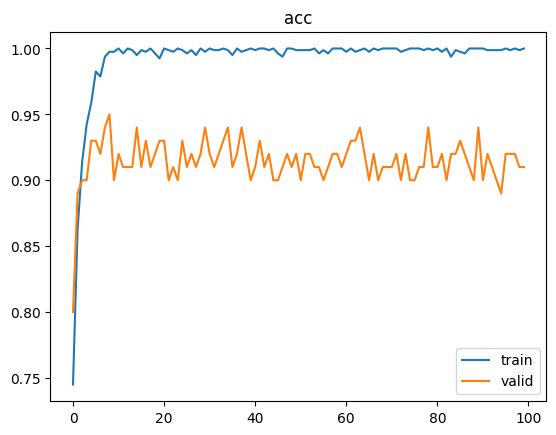

In [52]:
import matplotlib.pyplot as plt
plt.title("loss")
plt.plot(resnet34[0], label='train')
plt.plot(resnet34[1], label='valid')
plt.legend()
plt.show()
plt.title("acc")
plt.plot(resnet34[2], label='train')
plt.plot(resnet34[3], label='valid')
plt.legend()
plt.show()

In [53]:
test_file_list = glob.glob(f'{test_root}/*/*')
random.shuffle(test_file_list)

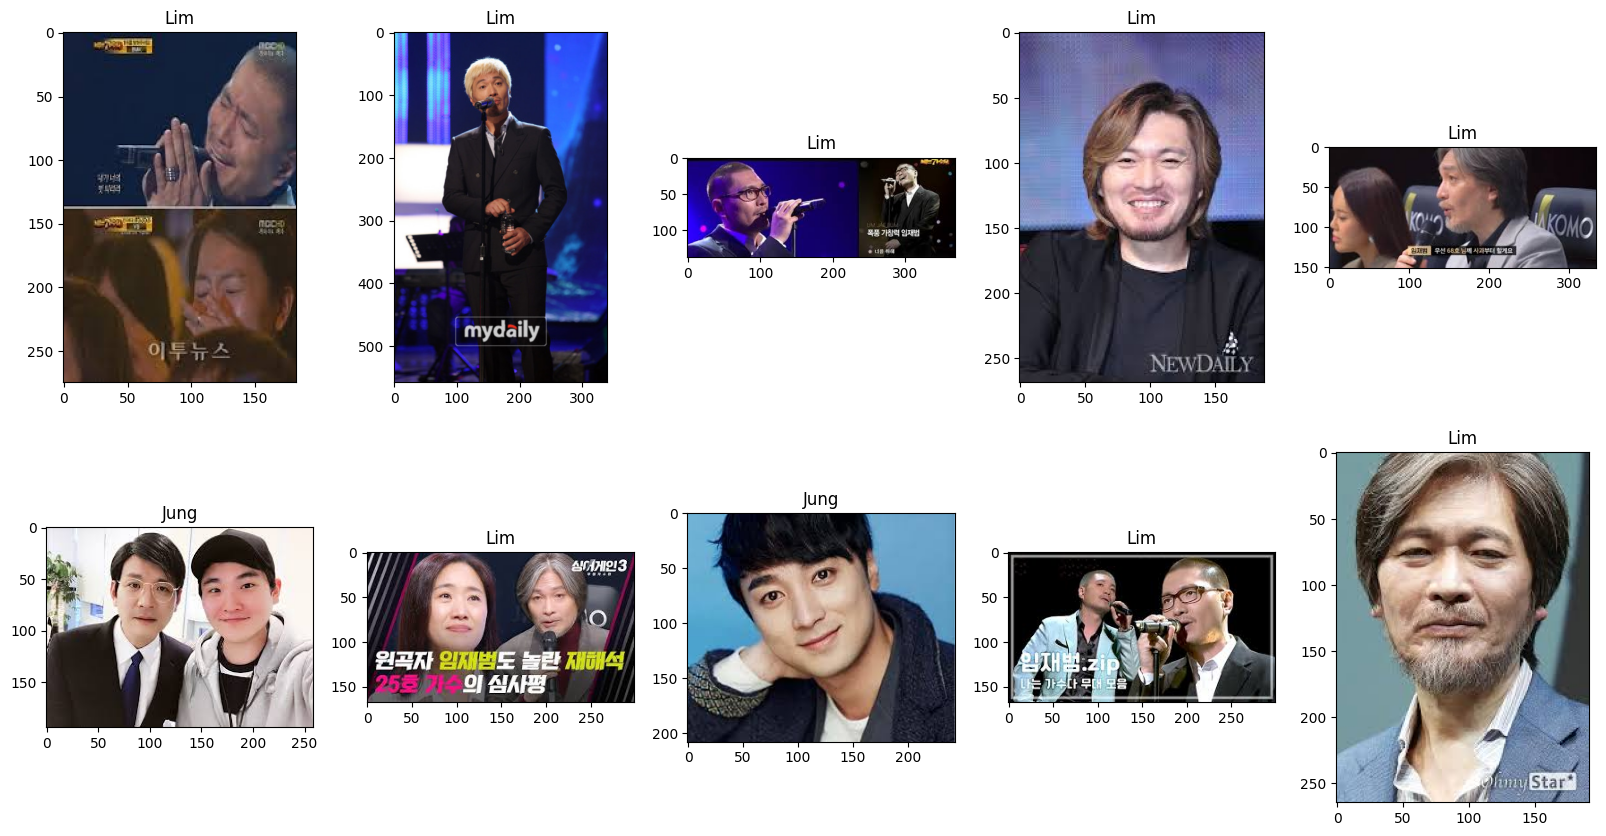

In [54]:
plt.figure(figsize = (20, 10))

for i in range(10) :
    test_img_path = os.path.join(test_root, test_file_list[i])
    ori_img = Image.open(test_img_path).convert('RGB')

    plt.subplot(2, 5, i + 1)
    plt.title(test_file_list[i].split('/')[-2])
    plt.imshow(ori_img)

In [55]:
test_data_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_test = datasets.ImageFolder(os.path.join(data_root, 'test'),
                                           test_data_transform)


test_dataloaders = torch.utils.data.DataLoader(image_test, batch_size = 16,
                                          shuffle = False)

test_dataset_size = len(image_test)
class_names = image_test.classes

In [60]:
def test_model(model,loss_func, dataloader, dataset_sizes, device) :
    since = time()
    model.eval()

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(dataloader) :
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad() :
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_func(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes
    epoch_acc = running_corrects.double() / dataset_sizes

    time_elapsed = time() - since

    print(f'Test complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Acc: {epoch_acc:.4f} Loss: {epoch_loss:.4f}')

In [61]:
resnet34 = timm.create_model('resnet34', pretrained = True, num_classes = num_class).to(device)
cp_path = f'{project_root}/models/JungLim_resnet34.pth'
resnet34.load_state_dict(torch.load(cp_path, map_location = device))

<ipython-input-61-ae43e1078c91>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet34.load_state_dict(torch.load(cp_path, map_location = device))


<All keys matched successfully>

In [62]:
test_model(resnet34, loss_func, test_dataloaders, test_dataset_size, device)

100%|██████████| 7/7 [00:00<00:00,  8.88it/s]

Test complete in 0m 1s
Acc: 0.9100 Loss: 0.2218


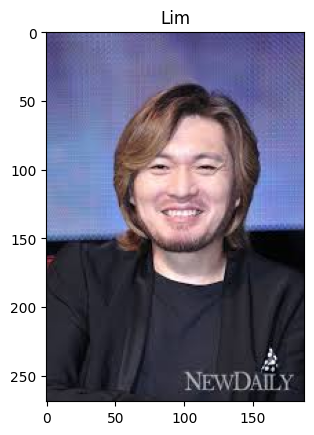

In [64]:
idx = 3

test_img_path = test_file_list[idx]
ori_img = Image.open(test_img_path).convert('RGB')
image = test_data_transform(ori_img)
x_tensor = image.to(device).unsqueeze(0)

resnet34.eval()

with torch.no_grad() :
    outputs = resnet34(x_tensor)
    _, y_pred = torch.max(outputs, 1)

plt.title(class_names[y_pred])
plt.imshow(ori_img)
plt.show()

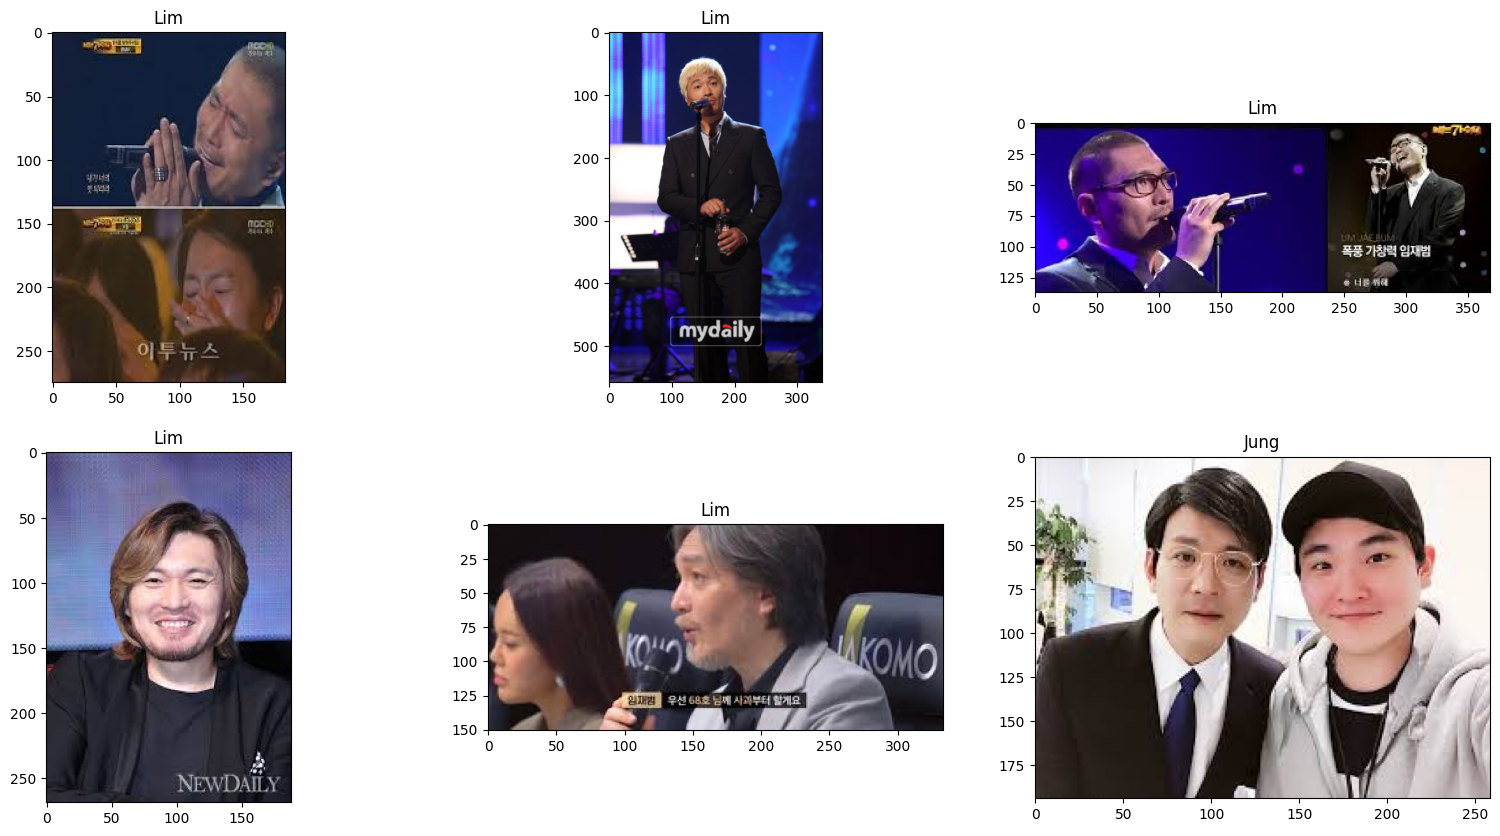

In [67]:
plt.figure(figsize = (20, 10))

for i in range(6) :
    test_img_path = os.path.join(test_root, test_file_list[i])
    ori_img = Image.open(test_img_path).convert('RGB')
    image = test_data_transform(ori_img)
    x_tensor = image.to(device).unsqueeze(0)

    outputs = resnet34(x_tensor)
    _, y_pred = torch.max(outputs, 1)

    plt.subplot(2, 3, i + 1)
    plt.title(class_names[y_pred])
    plt.imshow(ori_img)

plt.show()